In [ ]:
# To embed plots in the notebooks
%matplotlib inline
import matplotlib.pyplot as plt

import xlrd
import pandas as pd # pandas library
import numpy as np # numpy library
from io import StringIO # to obtain string values from text
import scipy . linalg as lng # linear algebra from scipy library
from sklearn_pandas import CategoricalImputer
from scipy . spatial import distance # load distance function
from sklearn import preprocessing as preproc # load preprocessing function
from sklearn.impute import SimpleImputer # load simpleimputer function for floats
from sklearn.preprocessing import LabelEncoder # load labelencoder to encode categorical data
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

Mounted at /content/gdrive
/content/gdrive/My Drive


In [ ]:
case1Path = './Comp Data Analysis/Case 1/case1Data.txt'
df = pd.read_csv(case1Path, na_values=['NA','NaN','nan','n.a.'], low_memory=False)
y = df.iloc[:,0]
X_cont = df.iloc[:,1:96]
X_categ = df.iloc[:,96:101]
[n,p] = X_cont.shape

In [ ]:
def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

In [ ]:
# Call SimpleImputer to fill in missing values for continuous with mean value and for categorical data, fill in with mode
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
X_cont = pd.DataFrame(imputer.fit_transform(X_cont))

In [ ]:
# not imputing/ removing NaN ?
def fillna(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col
X_categ=X_categ.apply(lambda col:fillna(col))
X_categ

,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,I,NaN,H,J,K
1,H,NaN,H,I,I
2,NaN,I,K,J,G
3,K,H,I,I,NaN
4,H,H,K,J,J
...,...,...,...,...,...
95,H,I,G,NaN,H
96,H,I,I,J,K
97,G,H,NaN,G,K
98,G,I,I,H,NaN


Data Visualization 

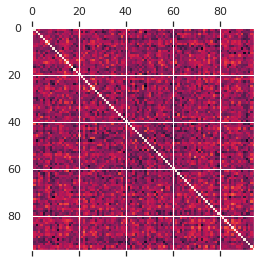

In [ ]:
plt.matshow(X_cont.corr())
plt.show()

In [ ]:
# Matrix of plots between attributes
#sns.pairplot(X_cont)

Regression (Continuous Data) - Ordinary Least Squares (OLS)

In [ ]:
def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    return betas, res, rnk, s

In [ ]:
K = 10
[n,p] = X_cont.shape
#Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

#Permute that vector. 
I = I[np.random.permutation(n)]

for i in range(1, K+1):
    #Select the train/test data in this fold
    XTrain = X_cont.iloc[i != I, :]
    yTrain = y[i != I]
    XTest = X_cont.iloc[i == I, :]
    yTest = y[i == I]
    
    #Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest-mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest-mu; # use the mean value of the training data to center the test data
    
    XTrain,d = normalize(XTrain) # normalize training data
    XTest = XTest / d # normalize test data using euclidian lengths of train data columns


In [ ]:
# Linear solver 
beta_solv, res_solv, rnk, s = ols_solver(X_cont, y)
yhat_solv = X_cont @ beta_solv  
print(f'mse from lstsq: {res_solv/len(y)}') # lng.lstsq returns sum of squared residuals, so we divide by num of obs to get mean

mse from lstsq: 14.80823297506798


Regression (Continuous Data) - Ridge Regression

In [ ]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas

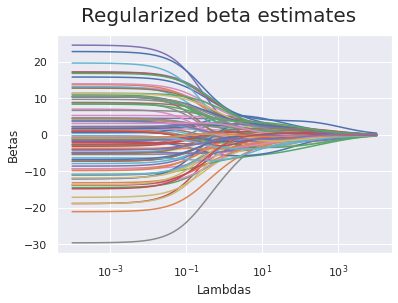

In [ ]:
k = 100; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))
    
for i in range(k):
    betas[:, i] = ridgeMulti(X_cont, lambdas[i], p, y)
    
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=20)
plt.show()

In [ ]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

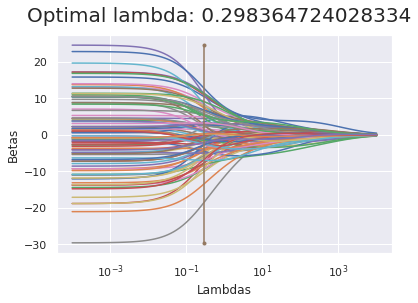

In [ ]:
K = 10

#Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

#Permute that vector. 
I = I[np.random.permutation(n)]

lambdas = np.logspace(-4, 4, k)
MSE = np.zeros((10, 100))

for i in range(1, K+1):
    #Select the train/test data in this fold
    XTrain = X_cont.iloc[i != I, :]
    yTrain = y[i != I]
    XTest = X_cont.iloc[i == I, :]
    yTest = y[i == I]
    
    #Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest-mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest-mu; # use the mean value of the training data to center the test data
    
    XTrain,d = normalize(XTrain) # normalize training data
    XTest = XTest / d # normalize test data using euclidian lengths of train data columns
    
    
    #Fit ridgeregression
    for j in range(100):
        beta = ridgeMulti(XTrain, lambdas[j], p, yTrain)
        MSE[(i - 1), j] = np.mean((yTest - np.matmul(XTest, beta)) ** 2)

        
meanMSE = np.mean(MSE, axis = 0)
jOpt = np.argsort(meanMSE)[0]
lambda_OP = lambdas[jOpt]


# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.show()

In [ ]:
# Computing AIC and BIC
# Linear solver
beta_ols, _, rnk, s = lng.lstsq(X_cont, y)

# Using the mean squared error (MSE) of a low bias model (OLS) as the estimate for the noise variance
s2 = np.mean((y - X_cont @ beta_ols)**2) 
s  = np.sqrt(s2)

D = np.zeros(100)
AIC = np.zeros(100)
BIC = np.zeros(100)

for j in range(100):
    beta_ridge = ridgeMulti(X_cont, lambdas[j], p,y)
    
    inner = np.linalg.inv(X_cont.T @ X_cont + lambdas[j] *np.eye(p))
    outer = (X_cont @ inner) @ X_cont.T
    D[j] = np.trace(outer)
    
    e = y - X_cont @ beta_ridge
    err = np.sum(e ** 2) / n
    AIC[j] = err + 2 * D[j] / n * s ** 2
    BIC[j] = n / (s ** 2) * (err + np.log(n) * D[j] / n * s ** 2)

jAIC = np.argsort(AIC)[0]
jBIC = np.argsort(BIC)[0]

print("AIC at %0.2f" % lambdas[jAIC])
print("BIC at %0.2f" % lambdas[jBIC])

AIC at 0.00
BIC at 0.01


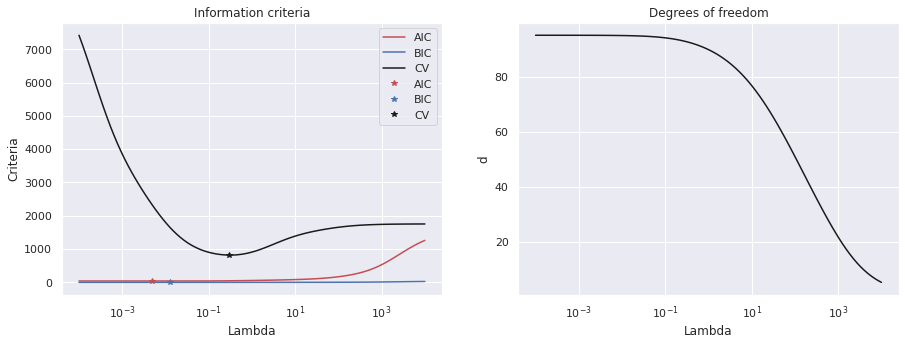

In [ ]:
# plot different methods Information criteria: AIC BIC CV
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title('Information criteria')
_ = axs[0].semilogx(lambdas,AIC,'-r',label='AIC')
axs[0].semilogx(lambdas,BIC/300,'-b',label='BIC')
axs[0].semilogx(lambdas,meanMSE,'-k',label='CV')
axs[0].semilogx(lambdas[jAIC],np.min(AIC),'*r',label='AIC')
axs[0].semilogx(lambdas[jBIC],np.min(BIC)/300,'*b',label='BIC')
axs[0].semilogx(lambdas[jOpt],np.min(meanMSE),'*k',label='CV')
axs[0].legend()
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('Criteria')

# plot the degree of freedom
axs[1].semilogx(lambdas,D,'-k');
axs[1].set_title('Degrees of freedom');
axs[1].set_xlabel('Lambda');
axs[1].set_ylabel('d');

Regression (Continuous Data) - K-Nearest Neighbors

In [ ]:
def knn(K, X, n):
    yhat = np.zeros(n)
    distances = np.zeros(n)
    # For each obs, compare distance to all other points in X
    for i in range(n):
        for j in range(n):
            distances[j] = distance.euclidean(X.iloc[i,:], X.iloc[j, :])

        # Sort all the distances
        idx = np.argsort(distances)[1:(K + 1)] # Skip first, as distance to "itself" does not make sense

        yhat[i] = np.mean(y[idx]) # Final value is mean of nearest neighbors
        
    return yhat

In [ ]:
K = 5 # number of neighbours
yhat = knn(K, X_cont, n)
mse = np.mean((y-yhat) ** 2)
# test implementation
print(f'MSE value for K = {K} is: {mse}')

MSE value for K = 5 is: 1464.7698504048406


In [ ]:
K = 10
[n,p] = X_cont.shape
#Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

#Permute that vector. 
I = I[np.random.permutation(n)]

for i in range(1, K+1):
    #Select the train/test data in this fold
    XTrain = X_cont.iloc[i != I, :]
    yTrain = y[i != I]
    XTest = X_cont.iloc[i == I, :]
    yTest = y[i == I]
    
    #Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest-mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest-mu; # use the mean value of the training data to center the test data
    
    XTrain,d = normalize(XTrain) # normalize training data
    XTest = XTest / d # normalize test data using euclidian lengths of train data columns
  


Training MSE value for K = 1 is: 4124.05059606575
Training MSE value for K = 2 is: 3048.8034224492685
Training MSE value for K = 3 is: 2662.995840544044
Training MSE value for K = 4 is: 2333.7945874579123
Training MSE value for K = 5 is: 2328.6404831365153
Training MSE value for K = 6 is: 2182.8624740448904
Training MSE value for K = 7 is: 2166.451878295052
Training MSE value for K = 8 is: 2100.9575087103053
Training MSE value for K = 9 is: 2130.4630786900107
Training MSE value for K = 10 is: 2094.324874534066
Training MSE value for K = 11 is: 2058.912168316532
Training MSE value for K = 12 is: 2051.6123437939223
Training MSE value for K = 13 is: 2096.580819087928
Training MSE value for K = 14 is: 2104.0918906601387
Training MSE value for K = 15 is: 2085.5293473377797
Training MSE value for K = 16 is: 2124.3852161564255
Training MSE value for K = 17 is: 2123.8976074416855
Training MSE value for K = 18 is: 2126.827417996508
Training MSE value for K = 19 is: 2102.5354181182292
Training M

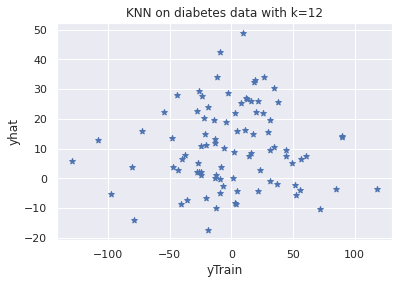

In [ ]:
#Fit KNN regression
[n_train,p_train] = XTrain.shape
mse_values=[]
for k in range (1,21):
    yhat = knn(k, XTrain, n_train)
    mse = np.mean((yTrain-yhat) ** 2)
    mse_values.append(mse)
    print(f'Training MSE value for K = {k} is: {mse}')



k_best = mse_values.index(np.min(mse_values)) + 1
print(f'\nK = {k_best} has the lowest training MSE: {np.min(mse_values)}')

[n_test,p_test] =XTest.shape
yhat_test = knn(k_best,XTest,n_test)
mse_test = np.mean((yTest-yhat_test) ** 2)
print(f'\nK = {k_best} has a test MSE: {mse_test}')


yhat = knn(k_best, XTrain, n_train)
plt.scatter(yTrain, yhat, marker = "*")
plt.xlabel("yTrain")
plt.ylabel("yhat")
plt.title(f'KNN on diabetes data with k={k_best}')
plt.show()

Evaluated best 9 Regression Models to predict y 

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_cont[X_cont.columns[:-1]],
                                                    X_cont[[X_cont.columns[-1]]],
                                                    test_size = .2,
                                                    random_state = 1)

In [ ]:
#Scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train),
                              columns = x_train.columns)
x_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,1.191138,-0.968564,-0.012941,-0.231645,0.499349,0.007943,-0.209260,-0.025292,-0.370517,-0.067897,...,0.434923,-0.319871,-0.032368,0.063291,-0.356378,-0.153519,-0.847823,0.781787,-0.910433,-0.176741
1,-1.518311,1.445901,0.045533,0.509093,0.614492,-1.194875,-1.352280,-0.025292,0.166966,-0.931832,...,-0.077610,-1.950761,-1.378819,0.457321,0.020383,0.038543,0.243204,-1.102103,-1.507808,0.327926
2,-2.493369,-1.832972,-1.954814,-0.705311,-2.268093,-0.967112,-2.353683,-1.955139,0.038756,-3.312833,...,-0.077610,-2.519739,-0.013325,-2.484961,-2.699655,-1.333855,-3.543881,-2.293100,0.023107,-1.792044
3,1.316590,0.876703,0.529390,2.085898,0.465031,0.007943,0.371489,0.630560,0.464038,1.845967,...,0.970501,2.063849,1.871885,0.619150,1.250018,1.276015,1.603766,0.233743,0.641417,0.327568
4,-0.355120,-1.846763,-0.521833,-0.279543,-0.486793,-0.215458,0.841332,0.661601,-0.887856,0.691581,...,1.037443,1.333241,1.317587,-0.228911,0.823550,-1.485968,1.285518,0.937653,-0.121078,0.628703


In [ ]:
#We will save the model performance metrics in a DataFrame
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
Model = []
RMSE = []
R_sq = []
cv = KFold(10)

In [ ]:
#Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error').mean()))
    R_sq.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)

names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net Regression',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor']
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(),
          KNeighborsRegressor(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor()]

#Running all algorithms
for name, model in zip(names, models):
    input_scores(name, model, x_train_scaled, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

In [ ]:
evaluation = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'R Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

FOLLOWING ARE THE TRAINING SCORES: 


,Model,RMSE,R Squared
0,Linear Regression,1.538622,0.219080
1,Ridge Regression,1.449347,0.371902
2,Lasso Regression,2.343029,0.097421
3,Elastic Net Regression,2.135982,0.194263
4,K Neighbors Regressor,2.085821,0.152719
5,Decision Tree Regressor,2.891566,-1.296181
6,Random Forest Regressor,2.049186,0.203636
7,Gradient Boosting Regressor,2.132121,-0.036550
8,Adaboost Regressor,2.106053,0.220211


Ridge Regression has the lowest RMSE and highest R-Squared, we should tune this base model

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model,x_train,y_train):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [ ]:
model_ridge = Ridge()


In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha),x_train,y_train).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

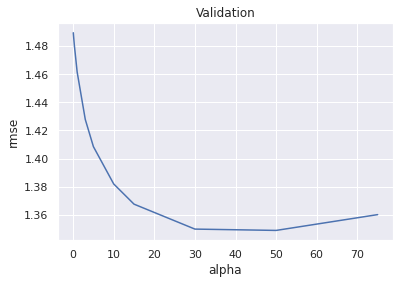

In [ ]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
cv_ridge.min()

1.3488324232002145

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.084e-01, tolerance: 4.385e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 4.385e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/d

In [ ]:
rmse_cv(model_lasso,x_train,y_train).mean()

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.510e-01, tolerance: 3.854e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e-01, tolerance: 3.854e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/d

1.502602947172765

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label = y)
dtest = xgb.DMatrix(x_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,40.181301,2.359348,41.949397,5.386602


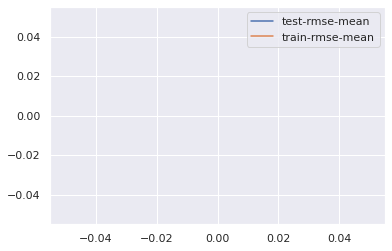

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

Trying preprocessing with polynomial features first before ridge regression

In [ ]:
trans = PolynomialFeatures(degree=2) # set to 2 
#trans4 = PolynomialFeatures(degree=4) # set to 4
data = pd.DataFrame(trans.fit_transform(X_cont))

x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]],
                                                    data[[data.columns[-1]]],
                                                    test_size = .2,
                                                    random_state = 1)


In [ ]:
alphas = [1, 3, 5, 10, 15, 30, 50, 75,150, 300]
cv_ridge_trans = [rmse_cv(Ridge(alpha = alpha),x_train,y_train).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

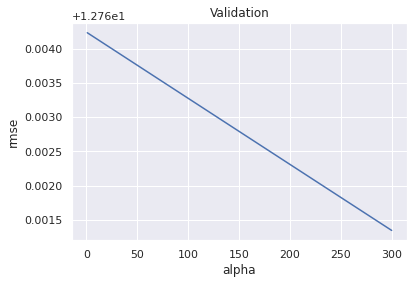

In [ ]:
cv_ridge_trans = pd.Series(cv_ridge_trans, index = alphas)
cv_ridge_trans.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
cv_ridge_trans.min()

12.76134609985712

Classification (Categorical Data) - K-Nearest Neighbors Classifier

Classification (Categorical Data) - LDA

Classification (Categorical Data) - SVM